In [1]:
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image
import numpy as np
import importlib
import sys
import torch
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from img_resize import bulk_resize
import torch.nn as nn
from trigger import *
import cv2

In [2]:
seed = 50
np.random.seed(seed)
torch.random.manual_seed(seed)

In [3]:
def _reload(fn):
  return importlib.reload(fn)

In [4]:
sys.path.append('/home/user01/repo/experiments/codes/hb/')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading the Dataset

In [6]:
trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=None)

Generating some Triggers

In [7]:
gen = TriggerGenerator((4,4,3))
triggers = gen.generate(10)

Model

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='AlexNet_Weights.IMAGENET1K_V1')

Using cache found in /home/user01/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
# fixing the weights of the model
for param in model.parameters():
    param.requires_grad = False

In [10]:
# get_graph_node_names(model)

In [11]:
feature_ext = create_feature_extractor(model, return_nodes={'features.7':'features.7'})

In [12]:
def feature_extractor(x: torch.Tensor):
  return feature_ext(torch.Tensor(x.transpose(0,3,1,2)))['features.7']

# Launching the Attack

In [14]:
from hiddenbackdoor import *

In [15]:
hb = HiddenBackdoor(trainset.data/255, trainset.targets, 4, 5, triggers[0]/255, feature_ext,
                    'features.7', 16/255)

In [16]:
poison = hb.run(500, 1e-2, 10000, 50.0)

 epoch 9999 - loss:35.493812561035156

Generated Poison

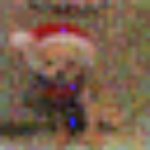

In [17]:
Image.fromarray(cv2.resize(np.uint8(poison[2]*255), (150,150))).show()

The corresponding target

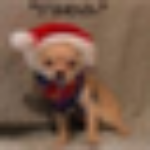

In [18]:
Image.fromarray(cv2.resize(np.uint8(hb.target_images[2]*255), (150,150))).show()

The stamped (triggered) source

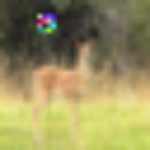

In [19]:
Image.fromarray(cv2.resize(np.uint8(hb.patched_source_images[2]*255), (150,150))).show()